# LSTM Neural Network

## Import

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import string
import re
import io


## Caricamento dei dati
Il dataset di partenza è stato preso da una [challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/) pubblicata su [Kaggle](https://www.kaggle.com/) nel 2018 da [Jigsaw](https://jigsaw.google.com/)

In [25]:
# Load data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [26]:
# Test data with labels
test_labels = pd.read_csv('data/test_labels.csv')
test_df = test_data.merge(test_labels)
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for s in labels:
    test_df = test_df[test_df[s] != -1]

test_data = test_df

## Data analysis (pt.1) e subsampling
Il dataset risulta essere molto sbilanciato, per questo motivo è stato optato per un subsampling della classe dominante, che risulta essere quella con tutte le classi poste a zero.  
Si è scelto di utilizzare la proporzione 50/50, dove metà del dataset risultano essere commenti "puliti", mentre l'altra metà dei record ha un qualche grado di tossicità.

In [27]:
def good_ppl_counter(data):
    count = 0
    for d in range(len(data)):
        if data['toxic'][d] == 0 and data['severe_toxic'][d] == 0 and data['obscene'][d] == 0 and data['threat'][d] == 0 and data['insult'][d] == 0 and data['identity_hate'][d] == 0:
            count += 1
    return count

def bad_ppl_counter(data):
    count = 0
    for d in range(len(data)):
        for s in labels:
            if data[s][d] == 1:
                count += 1
                break
    return count

# Length of the train data
print(f'Lenght of train data: {len(train_data)}')
print(f'Good people: {good_ppl_counter(train_data)}')
print(f'Bad people: {bad_ppl_counter(train_data)}')
print('..........')

# Record count for each label
for s in labels:
    print(f'{s}: {len(train_data[train_data[s] == 1])}')
print('..........')

# Record count for each label with toxic = 0
count = {}
for s in labels:
    count[s] = 0
for d in range(len(train_data)):
    for s in labels:
        if train_data['toxic'][d] == 0 and train_data[s][d] == 1:
            count[s] += 1
for k in count.keys():
    print(f'{k}: {count[k]}')

Lenght of train data: 159571
Good people: 143346
Bad people: 16225
..........
toxic: 15294
severe_toxic: 1595
obscene: 8449
threat: 478
insult: 7877
identity_hate: 1405
..........
toxic: 0
severe_toxic: 0
obscene: 523
threat: 29
insult: 533
identity_hate: 103


In [28]:
from sklearn.model_selection import train_test_split

# Split train data into train and validation and balance the data
train_df, val_df = train_test_split(train_data, test_size=0.1)
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_toxic = train_df[train_df[labels].sum(axis=1) > 0]
train_clean = train_df[train_df[labels].sum(axis=1) == 0]

train_data = pd.concat([
  train_toxic,
  train_clean.sample(20000)
])

In [29]:
# delete from dataframe the rows with nan values
test_data = test_data[~test_data['comment_text'].isna()]
test_data['comment_text'].isna().sum()
train_data = train_data[~train_data['comment_text'].isna()]
train_data['comment_text'].isna().sum()

0

### Pulizia dei dati
La pulizia dei dati si è divisa in vari sottopassaggi.  
Avendo come dominio il linguaggio naturale dobbiamo tenere conto di tutte le possibili variazioni che possono creare del rumore all'interno del dataset.

Come prima cosa abbiamo portato tutto il dataset in **caratteri minuscoli**, in quanto le lettere maiuscole sono caratteri diversi che veicolano le stesse informazioni di quelli minuscoli.

Dopo di che abbiamo fatto un primo passaggio di standardizzazione del linguaggio **eliminando tutte le contrazioni** presenti in lingua inglese e ponendole in forma estesa (es. "*you're*" -> "*you are*").

Insieme all'eliminazione delle contrazioni abbiamo fatto la **pulizia dello slang** solito dell'internet, andando a sostituire tutte quelle sigle, forme contratte ed abbreviazioni con la loro controparte "canonica" (es. "*m8*" -> "*mate*").

Dopo di che si è passati all'**eliminazione di tutti i caratteri speciali**, in particolare parliamo di simboli, link, tag HTML, caratteri non ASCII.  
Si è deciso quindi di eliminare anche la punteggiatura.

Infine è giunto il momento di **togliere le stopwords**, cioé tutte quelle parole di circostanza che aiutano nella forma ma non veicolano nessuna informazione utile (es. "*the*", "*and*" etc.)

Una volta fatto ciò sono stati **eliminati quegli ultimi tag rimasti** (```\r``` e ```\n```), **i caratteri di spazio ridondanti e quelli ad inizio e fine riga**.

In [30]:
# Cleaning
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import contractions
stop = set(stopwords.words('english'))

def cleaning(text):

    # Lower case
    text = text.lower()

    # Remove Contractions
    text = contractions.fix(text)

    # Remove special characters
    text = re.sub('\[.*?\]', '', text)

    # Remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Remove html tags
    text = re.sub ('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)

    # Remove non ASCII characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    # Remove punctuation
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Remove words with numbers in them
    text = re.sub('\w*\d\w*', '', text)

    # Remove Slangs
    text = slang_clean(text)

    # Remove stop words
    text = ' '.join(word for word in text.split(' ') if word not in stop)
    
    # Remove \n and \r
    text = re.sub(r'(\n)+', ' ', text)
    text = re.sub(r'(\r)+', '', text)

    # Remove starting and ending spaces
    text = re.sub(r'^\s+|\s+$', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    return text

def slang_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

train_data['text_clean'] = train_data['comment_text'].apply(lambda x: cleaning(x))
val_df['text_clean'] = val_df['comment_text'].apply(lambda x: cleaning(x))
test_data['text_clean'] = test_data['comment_text'].apply(lambda x: cleaning(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **📑 Part of Speech Tagging & Lemmatizzazione**
Successivamente alla pulizia del testo si può procedere al **Part of Speech Tagging**, cioè quell'operazione che associa ad ogni parola un tag tra i seguenti:
- N: noun (nome)
- V: verb (verbo)
- J: adj (aggettivo)
- R: adv (avverbio)

Questo permette all'operazione successiva, la **lemmatizzazione**, di avvenire in maniera migliore.

La lemmatizzazione è quell'operazione che porta tutti i sostantivi alla forma base, per esempio i verbi vengono tutti portati all'infinito e gli aggettivi vengono portati tutti alla forma base, andando a modificare eventuali superlativi etc.  
Abbiamo scelto di effettuare la lemmatizzazione anziché solo uno stemming in quanto abbiamo valutato che, per i nostri scopi, informazioni come il tempo verbale non fossero rilevanti, al contratio l'utilizzo di più parole per veicolare lo stesso messaggio avrebbe solo aggiunto rumore al nostro dataset.

In [31]:
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download('brown')

# Part of Speech Tagging
wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
    
train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    
    pos_tagged_text = t2.tag(text)
    
    # map the pos tagging output with wordnet output 
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
   
    return pos_tagged_text

# Lemmatization
def lemmatize_word(text):
    
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

# Apply Pos Tagging
train_data['separated'] = train_data['text_clean'].apply(lambda x: [x for x in x.split()])
train_data['text_pos'] = train_data['separated'].apply(lambda x: pos_tag_wordnet(x)) 
val_df['separated'] = val_df['text_clean'].apply(lambda x: [x for x in x.split()])
val_df['text_pos'] = val_df['separated'].apply(lambda x: pos_tag_wordnet(x))
test_data['separated'] = test_data['text_clean'].apply(lambda x: [x for x in x.split()])
test_data['text_pos'] = test_data['separated'].apply(lambda x: pos_tag_wordnet(x))

# Apply Lemmatization
train_data['text_lem_wpos'] = train_data['text_pos'].apply(lambda x: lemmatize_word(x))
train_data['text_lem'] = [' '.join(map(str,l)) for l in train_data['text_lem_wpos']]
val_df['text_lem_wpos'] = val_df['text_pos'].apply(lambda x: lemmatize_word(x))
val_df['text_lem'] = [' '.join(map(str,l)) for l in val_df['text_lem_wpos']]
test_data['text_lem_wpos'] = test_data['text_pos'].apply(lambda x: lemmatize_word(x))
test_data['text_lem'] = [' '.join(map(str,l)) for l in test_data['text_lem_wpos']]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


## Data analysis (Pt.2)
Dopo un primo preprocessing possiamo effettuare una seconda analisi dei dati, andando a creare delle wordcloud per l'intero dataset e per ogni singola classe di tossicità.

In [6]:
#train_data.to_csv('data/train_clean.csv', index=False)
#test_data.to_csv('data/test_clean.csv', index=False)

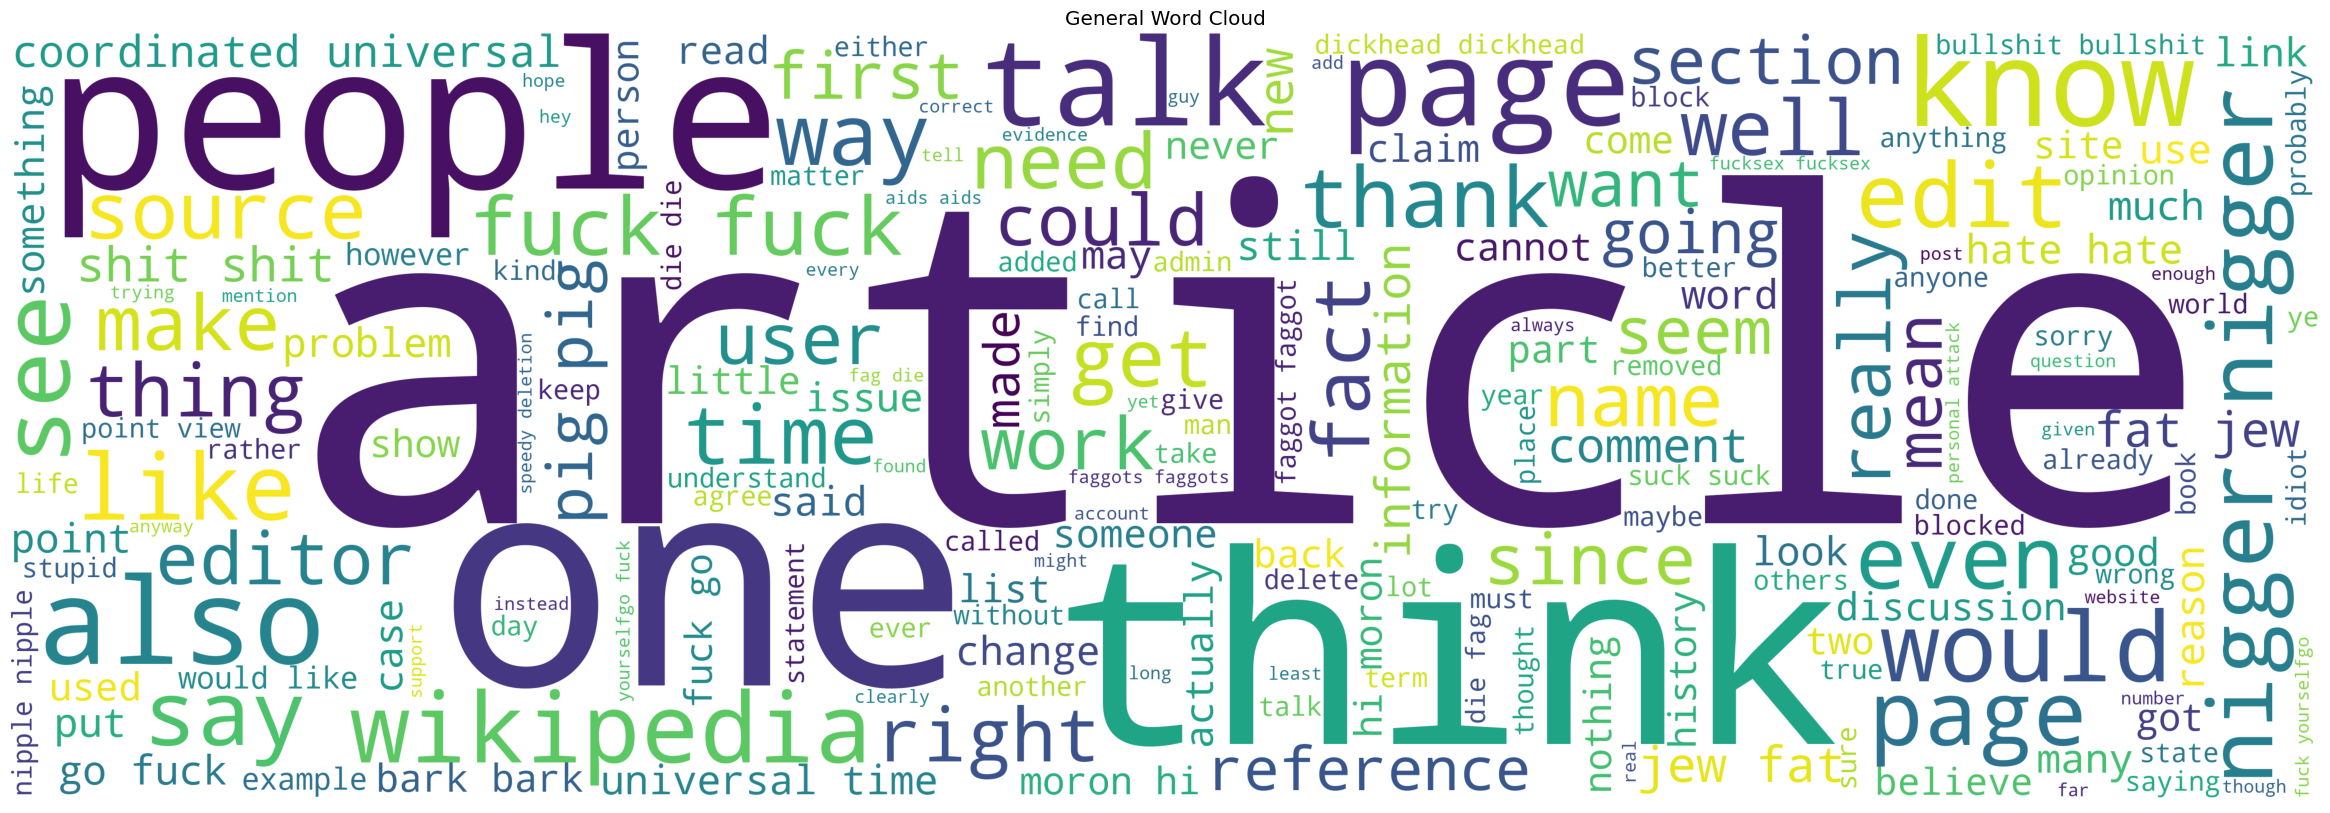

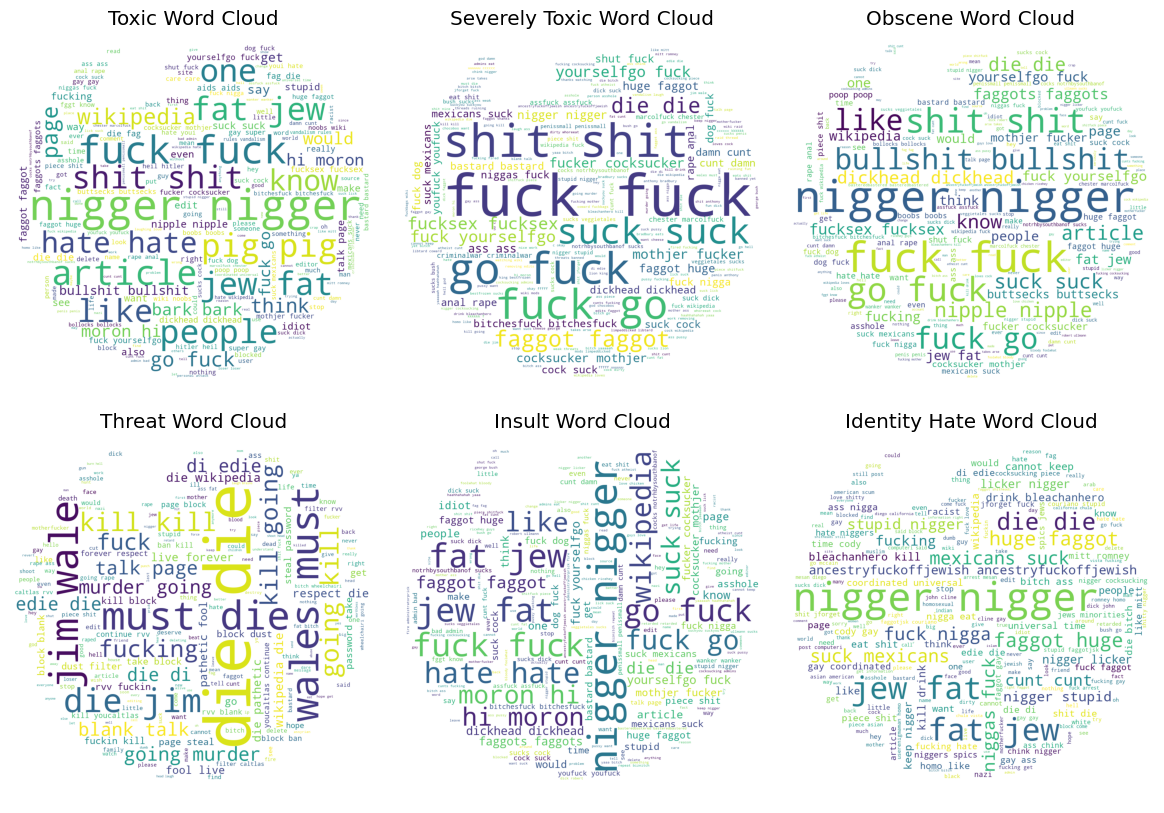

In [32]:
# Visualization
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')

mask = np.array(Image.open('./images/wikipedia_mask.jpg'))

def generate_wordcloud(df, clm):
    text = []
    comments = train_data.loc[df[clm] == 1]['text_clean']

    for c in comments:
        text.append(c) 
    words = ' '.join(text)
    return WordCloud(stopwords=stop, background_color='white', mask=mask, height=1500, width=1500).generate(words)

train_toxic = generate_wordcloud(train_data, 'toxic')
train_sev_toxic = generate_wordcloud(train_data, 'severe_toxic')
train_obscene = generate_wordcloud(train_data, 'obscene')
train_threat = generate_wordcloud(train_data, 'threat')
train_insult = generate_wordcloud(train_data, 'insult')
train_id_hate = generate_wordcloud(train_data, 'identity_hate')
train_general = WordCloud(stopwords=stop, background_color='white', height=1500, width=4500).generate(" ".join(train_data['text_clean']))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(45, 10), gridspec_kw = {'wspace':0.01, 'hspace':0.1})
axes.imshow(train_general)
axes.axis('off')
axes.set_title('General Word Cloud')

plt.show()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), gridspec_kw = {'wspace':0.01, 'hspace':0.1})


axes[0][0].imshow(train_toxic)
axes[0][0].axis('off')
axes[0][0].set_title('Toxic Word Cloud')
axes[0][0].set_aspect('equal')

axes[0][1].imshow(train_sev_toxic)
axes[0][1].axis('off')
axes[0][1].set_title('Severely Toxic Word Cloud')
axes[0][1].set_aspect('equal')

axes[0][2].imshow(train_obscene)
axes[0][2].axis('off')
axes[0][2].set_title('Obscene Word Cloud')
axes[0][2].set_aspect('equal')

axes[1][0].imshow(train_threat)
axes[1][0].axis('off')
axes[1][0].set_title('Threat Word Cloud')
axes[1][0].set_aspect('equal')

axes[1][1].imshow(train_insult)
axes[1][1].axis('off')
axes[1][1].set_title('Insult Word Cloud')
axes[1][1].set_aspect('equal')

axes[1][2].imshow(train_id_hate)
axes[1][2].axis('off')
axes[1][2].set_title('Identity Hate Word Cloud')
axes[1][2].set_aspect('equal')


plt.show()

## Salvataggio del dataset pulito
Commentato per non creare problemi nel momento in cui si vuole eseguire il notebook da zero eseguendo tutte le celle.

In [ ]:
header = ['text_lem', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#train_data.to_csv('data/train_clean.csv', columns = header, index = False)
#test_wlabels.to_csv('data/test_clean.csv', columns = header, index = False)

## Caricamento dati già puliti
Commentato per non creare problemi nel momento in cui si vuole eseguire il notebook da zero eseguendo tutte le celle.  
Nel caso si voglia caricare il dataset già pulito, basta decommentare la cella e far partire l'esecuzione dalla cella sottostante.

In [ ]:
#train_data = pd.read_csv('data/train_clean.csv')
#test_data = pd.read_csv('data/test_clean.csv')

# RETE NEURALE

In [33]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers

In [34]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [36]:
from keras_preprocessing.text import tokenizer_from_json
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_data['text_lem']))
list_tokenized_train = tokenizer.texts_to_sequences(train_data['text_lem'])
list_tokenized_val = tokenizer.texts_to_sequences(val_df['text_lem'])
list_tokenized_test = tokenizer.texts_to_sequences(test_data['text_lem'])
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_val = pad_sequences(list_tokenized_val, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
# save the tokenizer json in a file
import json
tokenizer_json = tokenizer.to_json()
with io.open('data/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [37]:
import zipfile
if not os.path.exists('data/glove.6B.50d.txt'):
    with zipfile.ZipFile('data/glove.6B.50d.zip', 'r') as zip_ref:
        zip_ref.extractall('data/')

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open("data/glove.6B.50d.txt", encoding="utf8"))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

# save embedding matrix
np.save('data/embedding_matrix.npy', embedding_matrix)

In [51]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_data[list_classes].values

checkpoint_path = "models/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True,verbose=1)

model.fit(X_t, y, validation_data=(X_val, val_df[list_classes].values), batch_size=16, epochs=5, callbacks=[cp_callback])

Epoch 1/5
2162/2162 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9222
Epoch 1: val_loss improved from inf to 0.06235, saving model to training\cp.ckpt
2162/2162 [==============================] - 127s 57ms/step - loss: 0.1983 - accuracy: 0.9222 - val_loss: 0.0623 - val_accuracy: 0.9948
Epoch 2/5
2162/2162 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9557
Epoch 2: val_loss improved from 0.06235 to 0.06021, saving model to training\cp.ckpt
2162/2162 [==============================] - 124s 58ms/step - loss: 0.1537 - accuracy: 0.9557 - val_loss: 0.0602 - val_accuracy: 0.9948
Epoch 3/5
2162/2162 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9461
Epoch 3: val_loss improved from 0.06021 to 0.05617, saving model to training\cp.ckpt
2162/2162 [==============================] - 118s 55ms/step - loss: 0.1394 - accuracy: 0.9461 - val_loss: 0.0562 - val_accuracy: 0.9946
Epoch 4/5
2162/2162 [=============================

In [54]:
# Load a model with custom weights
checkpoint_path = "training/cp.ckpt"
load_model = Model(inputs=inp, outputs=x)
load_model.load_weights(checkpoint_path)

In [55]:
y_test = load_model.predict([X_te], batch_size=16, verbose=1)

# Convert to binary
outputs =[]
for p in range(len(y_test)):
            aux = []
            for l in range(6):
                aux.append(int(y_test[p][l] >= 0.5))
            outputs.append(aux)


3999/3999 [==============================] - 29s 7ms/step


In [56]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    
    Take in np.array for y_true and y_pred. E.g.
    y_true = np.array([[0,1,0],
                       [0,1,1],
                       [1,0,1],
                       [0,0,1]])

    y_pred = np.array([[0,1,1],
                       [0,1,1],
                       [0,1,0],
                       [0,0,0]])
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [57]:
# Metrics
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

print(hamming_score(test_data[list_classes].values, outputs))
accuracy = []
test_label = test_data[list_classes].to_numpy()

for p in range(len(outputs)):
    correct_val = 0
    for i in range(6):
        if outputs[p][i] == test_label[p,i]:
            correct_val += 1
    accuracy.append(correct_val/6)

print(f'Accuracy: {np.mean(accuracy)}')

0.8386163993872894
Accuracy: 0.9545182198047246


In [60]:
from keras_preprocessing.text import tokenizer_from_json
import json

def model_pretrained():
    load_model = None
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    layers = Dense(6, activation="sigmoid")(x)
    checkpoint_path = "models/cp.ckpt"
    load_model = Model(inputs=inp, outputs=layers)
    load_model.load_weights(checkpoint_path)
    return load_model

def load_tokenizer():
    tokenizer_load = None
    with open('data/tokenizer.json') as f:
        data = json.load(f)
        tokenizer_load  = tokenizer_from_json(data)
    return tokenizer_load

def try_me(string):
    string = cleaning(string)
    model_loaded = model_pretrained()
    tokenizer_load = load_tokenizer()
    list_tokenized_string = tokenizer_load.texts_to_sequences([string])
    X_string = pad_sequences(list_tokenized_string, maxlen=maxlen)
    y_string = model_loaded.predict([X_string], batch_size=16, verbose=1)
    aux = []
    for l in range(6):
        aux.append(int(y_string[0][l] >= 0.5))
    
    print_string = f'Toxic: {bool(aux[0])} \nSevere Toxic: {bool(aux[1])} \nObscene: {bool(aux[2])} \nThreat: {bool(aux[3])} \nInsult: {bool(aux[4])} \nIdentity Hate: {bool(aux[5])}'

    return print(print_string)
    

In [62]:
try_me('I hate jews')

1/1 [==============================] - 0s 236ms/step
Toxic: True 
Severe Toxic: False 
Obscene: False 
Threat: False 
Insult: False 
Identity Hate: False
